In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools

In [2]:
import pandas as pd

benign_dataset = pd.read_csv('./output/benign/all_benign.txt')

In [3]:
max_length = 0
corpus = list()
labels = list()

with open(Path('./output/benign/all_benign.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(0)
  

In [4]:
with open(Path('./output/malware/all_malware.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
doc = ''
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(1)

In [5]:
len(corpus)

2800

In [6]:
len(labels)

2800

In [7]:
labels = np.array(labels)

In [17]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=192000)
print(X.shape)

(2800, 192000)


In [18]:
X = X.reshape(-1, 64, 3000)
print(X.shape)

(2800, 64, 3000)


In [19]:
vocab_size = len(tokenizer.word_index) + 1
print(f'노드 개수: {vocab_size}, 한 개 밖에 없는 노드:', end=' ')
unique_word = 0
for k in tokenizer.word_docs:
  if tokenizer.word_docs[k] == 1:
    unique_word += 1
print(unique_word)

노드 개수: 26, 한 개 밖에 없는 노드: 0


In [20]:
print(tokenizer.word_docs)

defaultdict(<class 'int'>, {'sub': 2796, 'add': 2799, 'shl': 2343, 'jz': 2770, 'call': 2786, 'mov': 2800, 'xchg': 1063, 'imul': 2438, 'jnb': 2490, 'xor': 2798, 'nop': 1470, 'push': 2789, 'cmp': 2785, 'jmp': 2785, 'movzx': 2368, 'lea': 2752, 'pop': 2790, 'retn': 2779, 'shr': 2477, 'or': 2729, 'dec': 2499, 'inc': 2587, 'rol': 911, 'retf': 492, 'ror': 611})


In [22]:
model = Sequential()
model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
                        input_shape=(64, 3000)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64, 64)           776448    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 801,345
Trainable params: 801,345
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
print(f'Train을 {X_train.shape}만큼, Test를 {X_test.shape}만큼 진행')

Train을 (1960, 64, 3000)만큼, Test를 (840, 64, 3000)만큼 진행


In [25]:
batch_size = 512
mc = ModelCheckpoint('./log/model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                    verbose=2, validation_split=0.1, callbacks=[mc])


Epoch 1/100
4/4 - 23s - loss: 0.6853 - accuracy: 0.5306 - val_loss: 0.6697 - val_accuracy: 0.6122 - 23s/epoch - 6s/step
Epoch 2/100
4/4 - 12s - loss: 0.6590 - accuracy: 0.6434 - val_loss: 0.6519 - val_accuracy: 0.6378 - 12s/epoch - 3s/step
Epoch 3/100
4/4 - 13s - loss: 0.6407 - accuracy: 0.6655 - val_loss: 0.6255 - val_accuracy: 0.6990 - 13s/epoch - 3s/step
Epoch 4/100
4/4 - 13s - loss: 0.6207 - accuracy: 0.7041 - val_loss: 0.6000 - val_accuracy: 0.7041 - 13s/epoch - 3s/step
Epoch 5/100
4/4 - 12s - loss: 0.6006 - accuracy: 0.7166 - val_loss: 0.5965 - val_accuracy: 0.7398 - 12s/epoch - 3s/step
Epoch 6/100
4/4 - 12s - loss: 0.5780 - accuracy: 0.7268 - val_loss: 0.5640 - val_accuracy: 0.7041 - 12s/epoch - 3s/step
Epoch 7/100
4/4 - 12s - loss: 0.5518 - accuracy: 0.7392 - val_loss: 0.5475 - val_accuracy: 0.7143 - 12s/epoch - 3s/step
Epoch 8/100
4/4 - 12s - loss: 0.5291 - accuracy: 0.7591 - val_loss: 0.5095 - val_accuracy: 0.7602 - 12s/epoch - 3s/step
Epoch 9/100
4/4 - 12s - loss: 0.4872 - a

In [26]:
model.load_weights('./log/model.h5')

In [27]:
y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [y >= 0.5 for y in y_pred]

print(metrics.classification_report(y_test, y_pred, digits=4))
with open('log/report.txt', 'w') as f:
  f.write(str(metrics.classification_report(y_test, y_pred, digits=4)))


2/2 [==============================] - 2s 501ms/step
              precision    recall  f1-score   support

           0     0.7978    0.8729    0.8337       425
           1     0.8560    0.7735    0.8127       415

    accuracy                         0.8238       840
   macro avg     0.8269    0.8232    0.8232       840
weighted avg     0.8266    0.8238    0.8233       840



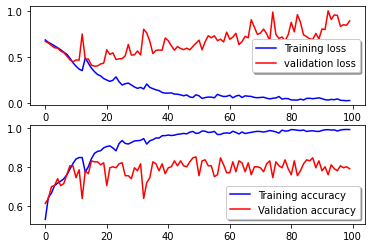

In [44]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

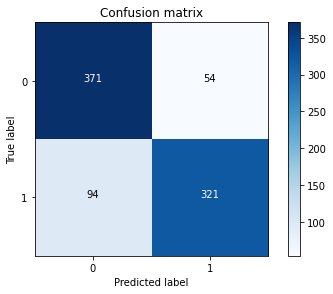

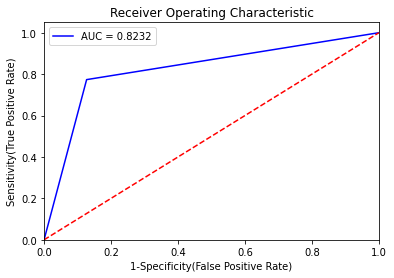

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), classes=[0, 1])
plt.savefig('log/confusion_matrix.png')

# Drawing ROC curve
plt.figure()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, color='blue', label='AUC = %0.4f' % (auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.savefig('log/roc.png')